# Chapter 7 - Ensemble Learning

## Project Preparation

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ensembles"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)



## Voting Classifier
### Hard Voting
Same training set for multiple algorithms
(Hard vote: majority-vote class will be predicted)

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver='lbfgs', random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma='scale', random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard'
)


In [4]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [5]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(f"{clf.__class__.__name__}: {accuracy_score(y_test, y_pred)}")


LogisticRegression: 0.864
RandomForestClassifier: 0.896
SVC: 0.896
VotingClassifier: 0.912


### Soft Voting

(Soft vote: class with highest average predict_proba will be predicted)

*Every estimator must have a predict_proba() method*

In [6]:
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft'
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

In [7]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(f"{clf.__class__.__name__}: {accuracy_score(y_pred, y_test)}")

LogisticRegression: 0.864
RandomForestClassifier: 0.896
SVC: 0.896
VotingClassifier: 0.92


## Bagging Classifier

Bagging: random training sets for the same algorithm

### Bagging Decision Trees
Original of Random Forests

In [8]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    base_estimator=DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=100, bootstrap=True, random_state=42
)

In [9]:
tree_clf = DecisionTreeClassifier(random_state=42)

In [10]:
from sklearn.metrics import accuracy_score

for clf, title in zip((bag_clf, tree_clf),
                      ('Bagging Classifier', 'Decision Tree')):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(f"{title}: {accuracy_score(y_pred, y_test)}")

Bagging Classifier: 0.904
Decision Tree: 0.856


In [11]:
from matplotlib.colors import ListedColormap

def round_to_half(num):
    return round(num * 2) / 2

def plot_decision_boundary(clf, X, y, alpha=0.5, contour=True):
    axes = [X[:, 0].min(), X[:, 0].max(), X[:, 1].min(), X[:, 1].max()]
    for i in range(4):
        axes[i] = round_to_half(axes[i])
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

Saving figure decision_tree_without_and_with_bagging_plot


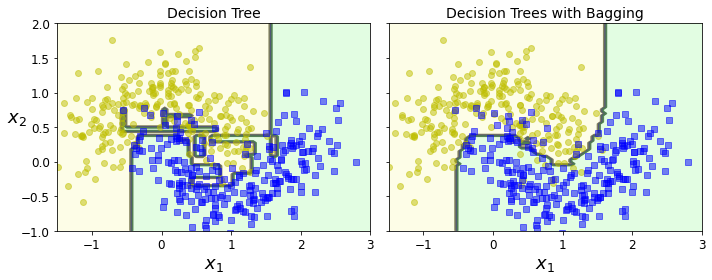

In [12]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")
save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()

### Out of Bag Evaluation

In [13]:
bag_clf_oob = BaggingClassifier(
    base_estimator=DecisionTreeClassifier(random_state=42), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True, random_state=40)
bag_clf_oob.fit(X_train, y_train)
y_pred = bag_clf_oob.predict(X_test)
bag_clf_oob.oob_score_, accuracy_score(y_pred, y_test)

(0.8986666666666666, 0.912)

In [14]:
bag_clf_oob.oob_decision_function_[:5,:]


array([[0.32275132, 0.67724868],
       [0.34117647, 0.65882353],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ]])

### Random Forest
Optimized (& Random splitter) version of Bagging Decision Trees


In [15]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter="random", max_leaf_nodes=16, random_state=42),
    n_estimators=500, max_samples=1.0, bootstrap=True, random_state=42)

bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [16]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42)
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)

In [17]:
np.sum(y_pred == y_pred_rf) / len(y_pred)

0.976

### Features Importance

In [18]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

In [19]:
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(n_jobs=-1, random_state=42)

In [20]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot,
               interpolation="nearest")
    plt.axis("off")

Saving figure mnist_feature_importance_plot


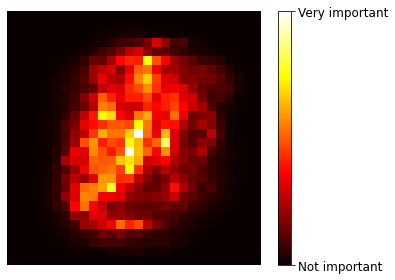

In [21]:
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

save_fig("mnist_feature_importance_plot")
plt.show()

In [22]:
rnd_clf.feature_importances_.shape

(784,)

In [23]:
mnist['data'].shape

(70000, 784)

## Boosting
Same predictor trained iteratively on the same dataset, but each predictor
tries to correct its predecessor

### AdaBoost Classifier
Tweaking instances weight after every iteration, calculate predictors' weights
(based on their error rates)

In [24]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm='SAMME.R', learning_rate=0.5
)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200)

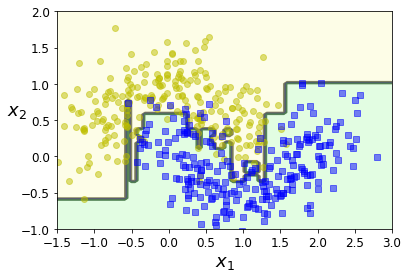

In [25]:
plot_decision_boundary(ada_clf, X, y)


### Boosting SVM Classifier
Weights of wrongly predicted samples get boosted by (1+learning_rate)
after every iteration.

Saving figure boosting_plot


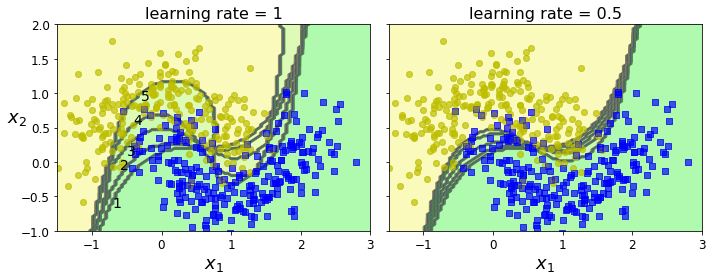

In [26]:
m = len(X_train)

fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
for subplot, learning_rate in ((0, 1), (1, 0.5)):
    sample_weights = np.ones(m)
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(kernel='rbf', C=0.05, gamma='scale', random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights)
        y_pred = svm_clf.predict(X_train)
        sample_weights[y_pred != y_train] *= (1 + learning_rate)
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title(f"learning rate = {learning_rate}", fontsize=16)
    if subplot == 0:
        plt.text(-0.7, -0.65, "1", fontsize=14)
        plt.text(-0.6, -0.10, "2", fontsize=14)
        plt.text(-0.5,  0.10, "3", fontsize=14)
        plt.text(-0.4,  0.55, "4", fontsize=14)
        plt.text(-0.3,  0.90, "5", fontsize=14)
    else:
        plt.ylabel("")

save_fig("boosting_plot")
plt.show()

### Gradient Boosting Regressor



In [27]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [28]:
from sklearn.ensemble import GradientBoostingRegressor
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3,
                                 learning_rate=1.0, random_state = 42)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

In [29]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)


GradientBoostingRegressor(max_depth=2, n_estimators=200, random_state=42)

In [30]:
X.shape

(100, 1)

In [31]:
def plot_predictions(regressor, X, y, axes, label=None, style="r-",
                     data_style="b.", data_label=None):
    x_coord = np.linspace(axes[0], axes[1], 500)
    y_pred = regressor.predict(x_coord.reshape(-1, 1))
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x_coord, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

Saving figure gbrt_learning_rate_plot


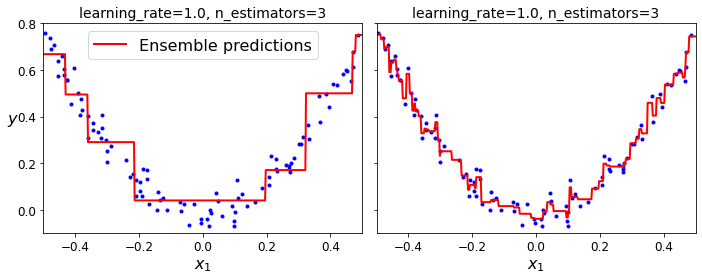

In [32]:
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

plt.sca(axes[0])
plot_predictions(gbrt, X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title(f"learning_rate={gbrt.learning_rate}, n_estimators={gbrt.n_estimators}", fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.sca(axes[1])
plot_predictions(gbrt_slow, X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title(f"learning_rate={gbrt.learning_rate}, n_estimators={gbrt.n_estimators}", fontsize=14)
plt.xlabel("$x_1$", fontsize=16)

save_fig("gbrt_learning_rate_plot")
plt.show()

### Gradient Boosting Regressor [Early Stopping]

#### Using staged_predict(X_test) method
Required pre-train a large number of trees -> choose the optimal number of trees

In [33]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)
gbrt.staged_predict(X_val)  # Iterator that yield predictions at each stage of boosting

<generator object GradientBoostingRegressor.staged_predict at 0x00000110360DE3C8>

In [34]:
errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
best_n_estimators = np.argmin(errors) + 1
gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=best_n_estimators)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=56)

In [35]:
?np.argmin  # Return the indices of the min values in an array-like

Object `np.argmin  # Return the indices of the min values in an array-like` not found.


Saving figure early_stopping_gbrt_plot


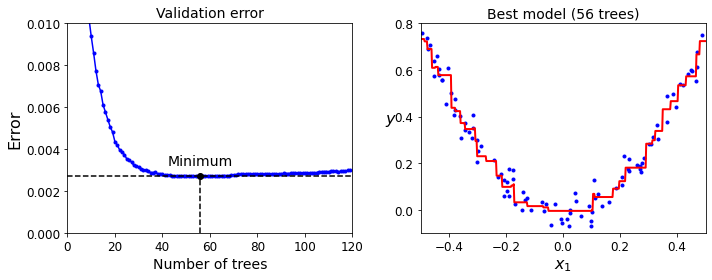

In [36]:
min_error = np.min(errors)
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([best_n_estimators, best_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(best_n_estimators, min_error, "ko")
plt.text(best_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions(gbrt_best, X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % best_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

save_fig("early_stopping_gbrt_plot")
plt.show()


#### Using parameter warm_start=True
Incremental training, stop as the validation errors does not improve for a
number of iterations in a row (e.g. 5 iterations)

In [37]:
# warm_start=True:  reuse the solution of the previous call to fit and add
# more estimators to the ensemble

gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True)
min_val_error = np.inf
error_going_up = 0

for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # stop the loop as soon as the error does not go down in 5 consecutive iterations


In [44]:
gbrt.n_estimators

61

### XGBoost


In [55]:
import xgboost as xgb

xgb_reg = xgb.XGBRegressor(random_state=42)
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_val)
val_error = mean_squared_error(y_val, y_pred)
print("Validation MSE:", val_error)


Validation MSE: 0.004000408205406276


In [57]:
xgb_reg.fit(X_train, y_train,
            eval_set=[(X_val, y_val)], early_stopping_rounds=2)
y_pred = xgb_reg.predict(X_val)
val_error = mean_squared_error(y_val, y_pred)
print("Validation error:", val_error)

[0]	validation_0-rmse:0.22834
[1]	validation_0-rmse:0.16224
[2]	validation_0-rmse:0.11843
[3]	validation_0-rmse:0.08760
[4]	validation_0-rmse:0.06848
[5]	validation_0-rmse:0.05709
[6]	validation_0-rmse:0.05297
[7]	validation_0-rmse:0.05129
[8]	validation_0-rmse:0.05155
[9]	validation_0-rmse:0.05211
Validation error: 0.002630868681577655
